## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import json

from tests.eas.load_tracking import FreqInvarianceTest
from trace import Trace
from trappy.plotter import plot_trace
from trappy.stats.grammar import Parser
from trappy import ILinePlot

In [3]:
import logging
from conf import LisaLogging
LisaLogging.setup()
logging.getLogger('Analysis').setLevel(logging.ERROR)
logging.getLogger('Trace').setLevel(logging.ERROR)

2016-12-02 18:43:24,299 INFO    : root         : Using LISA logging configuration:
2016-12-02 18:43:24,300 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


## Run test workload

In [4]:
t = FreqInvarianceTest(methodName='test_task_util')
# help(t)

In [5]:
t.setUpClass()

2016-12-02 18:43:24,314 INFO    : LisaTest     : Setup tests execution engine...
2016-12-02 18:43:24,315 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2016-12-02 18:43:24,316 INFO    : TestEnv      : Loading default (file) target configuration
2016-12-02 18:43:24,316 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2016-12-02 18:43:24,319 INFO    : TestEnv      : Loading custom (inline) test configuration
2016-12-02 18:43:24,320 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cpufreq']
2016-12-02 18:43:24,321 INFO    : TestEnv      : Connecting linux target:
2016-12-02 18:43:24,322 INFO    : TestEnv      :   username : brendan
2016-12-02 18:43:24,323 INFO    : TestEnv      :       host : 192.168.2.2
2016-12-02 18:43:24,324 INFO    : TestEnv      :   password : password
2016-12-02 18:43:24,325 INFO    : TestEnv      : Connection settings:
2016-12-02 18:43:24,326 INFO    : TestEnv      :    {

2016-12-02 18:44:12,211 INFO    : Executor     : Collected FTrace binary trace:
2016-12-02 18:44:12,213 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace.dat
2016-12-02 18:44:12,214 INFO    : Executor     : Collected FTrace function profiling:
2016-12-02 18:44:12,215 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace_stat.json
2016-12-02 18:44:12,216 INFO    : Executor     : --------------------------------------------------------------------------------
2016-12-02 18:44:12,217 INFO    : Executor     : 
2016-12-02 18:44:12,218 INFO    : Executor     : ================================================================================
2016-12-02 18:44:12,220 INFO    : Executor     : configuring target for [freq_625000] experiments
2016-12-02 18:44:13,947 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-12-02 18:44:14,854 INFO    : root         :        CPUFreq - CPU frequencies: {1: 625000}
2016-12-02 18:4

2016-12-02 18:44:39,592 INFO    : Executor     : Collected FTrace binary trace:
2016-12-02 18:44:39,594 INFO    : Executor     :    <res_dir>/rtapp:freq_625000:fie_10pct/1/trace.dat
2016-12-02 18:44:39,595 INFO    : Executor     : Collected FTrace function profiling:
2016-12-02 18:44:39,596 INFO    : Executor     :    <res_dir>/rtapp:freq_625000:fie_10pct/1/trace_stat.json
2016-12-02 18:44:39,598 INFO    : Executor     : --------------------------------------------------------------------------------
2016-12-02 18:44:39,599 INFO    : Executor     : 
2016-12-02 18:44:39,600 INFO    : Executor     : ================================================================================
2016-12-02 18:44:39,601 INFO    : Executor     : configuring target for [freq_800000] experiments
2016-12-02 18:44:41,322 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-12-02 18:44:42,229 INFO    : root         :        CPUFreq - CPU frequencies: {1: 800000}
2016-12-02 18:4

2016-12-02 18:45:14,041 INFO    : Executor     : Collected FTrace binary trace:
2016-12-02 18:45:14,043 INFO    : Executor     :    <res_dir>/rtapp:freq_800000:fie_10pct/1/trace.dat
2016-12-02 18:45:14,045 INFO    : Executor     : Collected FTrace function profiling:
2016-12-02 18:45:14,046 INFO    : Executor     :    <res_dir>/rtapp:freq_800000:fie_10pct/1/trace_stat.json
2016-12-02 18:45:14,047 INFO    : Executor     : --------------------------------------------------------------------------------
2016-12-02 18:45:14,048 INFO    : Executor     : 
2016-12-02 18:45:14,049 INFO    : Executor     : ================================================================================
2016-12-02 18:45:14,050 INFO    : Executor     : configuring target for [freq_950000] experiments
2016-12-02 18:45:15,769 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-12-02 18:45:16,675 INFO    : root         :        CPUFreq - CPU frequencies: {1: 950000}
2016-12-02 18:4

2016-12-02 18:45:47,095 INFO    : Executor     : Collected FTrace binary trace:
2016-12-02 18:45:47,097 INFO    : Executor     :    <res_dir>/rtapp:freq_950000:fie_10pct/1/trace.dat
2016-12-02 18:45:47,098 INFO    : Executor     : Collected FTrace function profiling:
2016-12-02 18:45:47,099 INFO    : Executor     :    <res_dir>/rtapp:freq_950000:fie_10pct/1/trace_stat.json
2016-12-02 18:45:47,100 INFO    : Executor     : --------------------------------------------------------------------------------
2016-12-02 18:45:47,101 INFO    : Executor     : 
2016-12-02 18:45:47,102 INFO    : Executor     : ================================================================================
2016-12-02 18:45:47,103 INFO    : Executor     : configuring target for [freq_1100000] experiments
2016-12-02 18:45:48,821 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-12-02 18:45:49,727 INFO    : root         :        CPUFreq - CPU frequencies: {1: 1100000}
2016-12-02 18

2016-12-02 18:46:13,534 INFO    : Executor     : Collected FTrace binary trace:
2016-12-02 18:46:13,536 INFO    : Executor     :    <res_dir>/rtapp:freq_1100000:fie_10pct/1/trace.dat
2016-12-02 18:46:13,537 INFO    : Executor     : Collected FTrace function profiling:
2016-12-02 18:46:13,538 INFO    : Executor     :    <res_dir>/rtapp:freq_1100000:fie_10pct/1/trace_stat.json
2016-12-02 18:46:13,540 INFO    : Executor     : --------------------------------------------------------------------------------
2016-12-02 18:46:13,541 INFO    : Executor     : 
2016-12-02 18:46:13,543 INFO    : Executor     : ################################################################################
2016-12-02 18:46:13,544 INFO    : Executor     : Experiments execution completed
2016-12-02 18:46:13,546 INFO    : Executor     : ################################################################################
2016-12-02 18:46:13,547 INFO    : Executor     : Results available in:
2016-12-02 18:46:13,549 INFO  

## Show variance in util_avg and load_avg
We want to see the same util_avg and load_avg values regardless of frequencies - the bar charts below should have all the same

In [6]:
# Get the frequency an experiment was run at
def experiment_freq(exp):
    [cpu] = exp.wload.cpus
    freq = exp.conf['cpufreq']['freqs'][cpu]
    return freq
freqs = [experiment_freq(e) for e in t.executor.experiments]
freqs

[450000, 625000, 800000, 950000, 1100000]

In [7]:
def plot_signal_against_freq(signal):
    means = [t.get_signal_mean(e, signal) for e in t.executor.experiments]
    limits = (min(means) * 0.99, max(means) * 1.01)
    pd.DataFrame(means, index=freqs, columns=['Mean ' + signal]).plot(kind='bar', ylim=limits)

### Plot of variation of util_avg value with frequency:

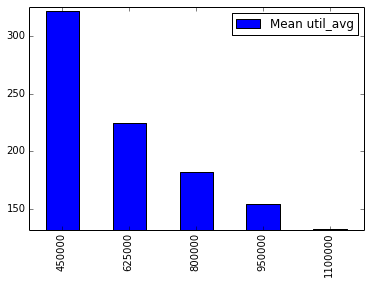

In [8]:
plot_signal_against_freq('util_avg')

### And the same thing for load_avg:

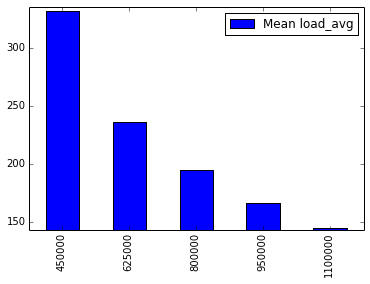

In [9]:
plot_signal_against_freq('load_avg')

## Examine trace from workload execution

Plot the `sched_util` and `sched_load` 

In [11]:
signals = ['util_avg', 'load_avg']
def examine_experiment(idx):
    experiment = t.executor.experiments[idx]
    
    print "Experiment configuration:" 
    print json.dumps(experiment.conf, indent=4)
    events = t.te.test_conf["ftrace"]["events"]
    
    # todo add get_trace method
    tasks = experiment.wload.tasks.keys()
    #trace = Trace(t.te.platform, experiment.out_dir, events, tasks)
    #print "Trace plot:"
    #plot_trace(trace.ftrace)
    
    # Get observed signal
    signal_df = t.get_sched_signals(experiment, signals)
#    return signal_df
    # Get expected average value for util_avg signal
    expected_util_avg_mean = t.get_expected_util_avg(experiment)
    
    # Plot util avg signal with expected mean value
    util_avg_mean = pd.Series([expected_util_avg_mean], name="expected_util_avg", index=[signal_df.index[0]])
    df = pd.concat([signal_df, util_avg_mean], axis=1).fillna(method="ffill")
    ILinePlot(df, column=signals + ["expected_util_avg"], drawstyle="steps-post").view()

In [12]:
examine_experiment(0)

Experiment configuration:
{
    "dtb": null, 
    "kernel": null, 
    "tag": "freq_450000", 
    "flags": "ftrace", 
    "cpufreq": {
        "freqs": {
            "1": 450000
        }, 
        "governor": "userspace"
    }
}


""
""
